In [1]:
import sys
sys.path.append(r'\Users\shadd\OneDrive\Documents\Python\impedance.py')
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from impedance.circuits import CustomCircuit
from impedance.plotting import plot_nyquist
from impedance import preprocessing
from impedance import validation

import ImpedanceCorrection as IC
import IC_plotting
%reload_ext autoreload
%autoreload 2

In [167]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*10%*.par')
all_files.sort()

f_name=all_files[-1]
print(f_name)
f0, Z0= preprocessing.readVersaStudio(f_name)

freqs, Z1 = preprocessing.ignoreBelowX(f0, Z0)

Z = Z1 - Z1.real[0]

C:\Users\shadd\OneDrive\Documents\Python\EIS
C:\Users\shadd\OneDrive\Documents\Python\EIS\Data\LSC_DPB1_FRXAS_700C_10%_EIS_OCV_afterFRXAS.par


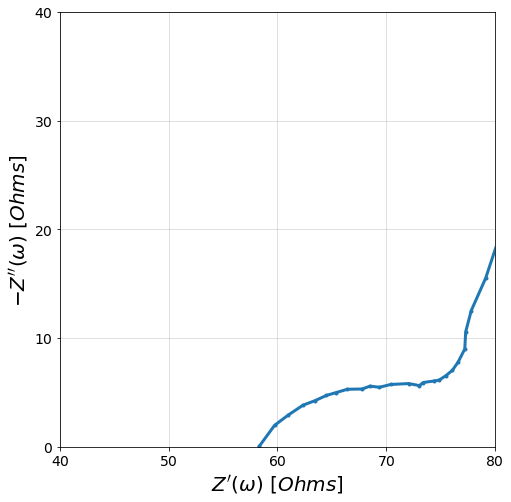

In [162]:
fig, ax = plt.subplots(figsize=(8,8))

plot_nyquist(ax, freqs, Z1)
ax.set_xlim(40,80)
ax.set_ylim(0,40)
plt.show()

## Trying to fit the high frequency arc

In [163]:
circ = 'R0-p(R1,E1)'

vals = [58, 20, 2e-7, .8]

circuit1 = CustomCircuit(circ, initial_guess=vals) #, constants={'R0': 58})
circuit2 = CustomCircuit(circ, initial_guess=vals) #, constants={'R0': 58})

In [164]:
circuit1.fit(freqs[:15], Z1[:15])
print(circuit1)

sigma_re = np.ones(freqs[:15].shape)
sigma_im = np.ones(freqs[:15].shape)
sigma_re[:10]= .6
sigma_im[-10:] = 2

sigma = np.hstack([sigma_re,sigma_im])

circuit2.fit(freqs[:15], Z1[:15], sigma=sigma)
print(circuit2)


Circuit string: R0-p(R1,E1)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
     R1 = 2.00e+01 [Ohm]
   E1_0 = 2.00e-07 [Ohm^-1 sec^a]
   E1_1 = 8.00e-01 []

Fit parameters:
     R0 = 5.91e+01  (+/- 9.11e-01) [Ohm]
     R1 = 1.92e+01  (+/- 2.33e+00) [Ohm]
   E1_0 = 2.85e-05  (+/- 2.11e-05) [Ohm^-1 sec^a]
   E1_1 = 7.21e-01  (+/- 7.55e-02) []


Circuit string: R0-p(R1,E1)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
     R1 = 2.00e+01 [Ohm]
   E1_0 = 2.00e-07 [Ohm^-1 sec^a]
   E1_1 = 8.00e-01 []

Fit parameters:
     R0 = 5.83e+01  (+/- 1.08e+00) [Ohm]
     R1 = 1.76e+01  (+/- 2.63e+00) [Ohm]
   E1_0 = 1.30e-05  (+/- 1.20e-05) [Ohm^-1 sec^a]
   E1_1 = 7.72e-01  (+/- 9.12e-02) []



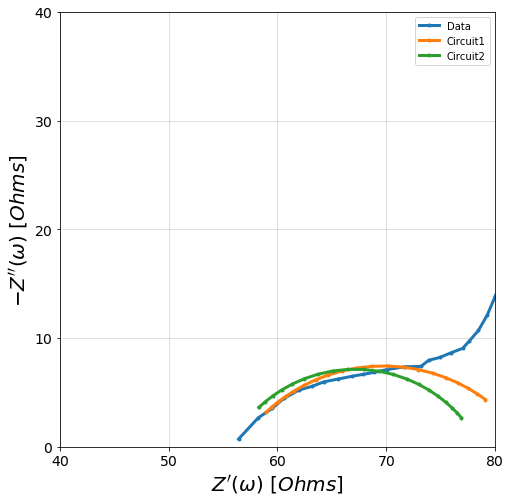

In [6]:
fig, ax = plt.subplots(figsize=(8,8))

plot_nyquist(ax, freqs, Z1)
plot_nyquist(ax, freqs, circuit1.predict(freqs[:20]), )
plot_nyquist(ax, freqs, circuit2.predict(freqs[:20]), )
ax.set_xlim(40,80)
ax.set_ylim(0,40)

ax.legend(labels=('Data', 'Circuit1','Circuit2'))
plt.show()

## That doesn't seem to be working well. Let's just cut off the arc for now and see if it works

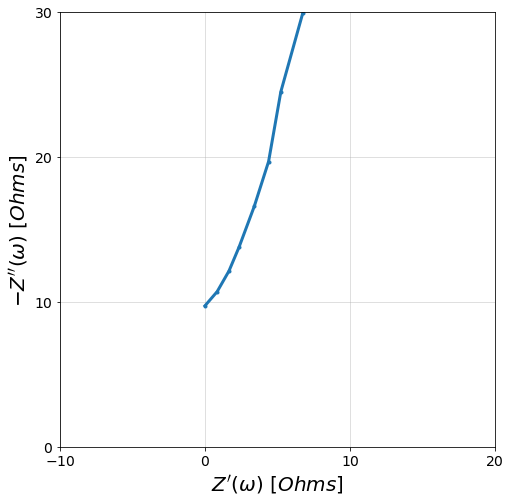

In [168]:
f_adj, Z_adj = freqs[18:], Z1[18:]

Z_adj = Z_adj - Z_adj.real[0]

fig, ax = plt.subplots(figsize=(8,8))

plot_nyquist(ax, f_adj, Z_adj)

ax.set_xlim(-10, 20)
ax.set_ylim(0,30)
plt.show()

### Subtracting a Gerischer admittance from this using tg=0.91 as fit from fr-XAS
### Varying the Rg to see what might be appropriate

In [156]:
def sub_Zg_parallel(f, Z, tg, Rg_range, num):
    from impedance.circuit_elements import G
    Y = 1/Z
    
    Zgs = []
    Ygs = []
    
    Rgs = np.logspace(Rg_range[0], Rg_range[1], num=num)
    
    for Rg in Rgs:
        Zg = G([Rg, tg], f)
        Zgs.append(Zg)
        Ygs.append(1/Zg)
    
    Zgs = np.array(Zgs)
    Ygs = np.array(Ygs)
    
    fig, ax = plt.subplots(figsize=(18,12))
    fig2, (ax1, ax2) = plt.subplots(nrows=2, figsize=(30,20))
    plot_nyquist(ax, f_adj, Z_adj)


    for i, Yg in enumerate(Ygs):
        Y_adj = Y - Yg
        f_p = f_adj[np.argmin(np.imag(1/(Y_adj)))]
        ax.plot(np.real(1/(Y_adj)), -np.imag(1/(Y_adj)), label='%.2f' % f_p, c=(0, i/len(Ygs),.4))
        ax1.plot(np.log10(f_adj), np.real(1/(Y_adj)) , label='%.2f' % Rgs[i], c=(0, i/len(Ygs),.4))
        ax2.plot(np.log10(f_adj), np.imag(1/(Y_adj)) , label='%.2f' % Rgs[i], c=(0, i/len(Ygs),.4))

    # ax.set_xlim(-80, 300)
    # ax.set_ylim(-80, 300)
    ax1.grid(True)
    ax2.grid(True)
    ax.legend()
    plt.show()
    return

In [ ]:
def sub_Zg_series(f, Z, tg, Rg_range, num):
    from impedance.circuit_elements import G
        
    Zgs = []
        
    Rgs = np.logspace(Rg_range[0], Rg_range[1], num=num)
    
    for Rg in Rgs:
        Zg = G([Rg, tg], f)
        Zgs.append(Zg)
            
    Zgs = np.array(Zgs)
        
    fig, ax = plt.subplots(figsize=(18,12))
    fig2, (ax1, ax2) = plt.subplots(nrows=2, figsize=(30,20))
    plot_nyquist(ax, f_adj, Z_adj)


    for i, Yg in enumerate(Ygs):
        Y_adj = Y - Yg
        f_p = f_adj[np.argmin(np.imag(1/(Y_adj)))]
        ax.plot(np.real(1/(Y_adj)), -np.imag(1/(Y_adj)), label='%.2f' % f_p, c=(0, i/len(Ygs),.4))
        ax1.plot(np.log10(f_adj), np.real(1/(Y_adj)) , label='%.2f' % Rgs[i], c=(0, i/len(Ygs),.4))
        ax2.plot(np.log10(f_adj), np.imag(1/(Y_adj)) , label='%.2f' % Rgs[i], c=(0, i/len(Ygs),.4))

    # ax.set_xlim(-80, 300)
    # ax.set_ylim(-80, 300)
    ax1.grid(True)
    ax2.grid(True)
    ax.legend()
    plt.show()
    return

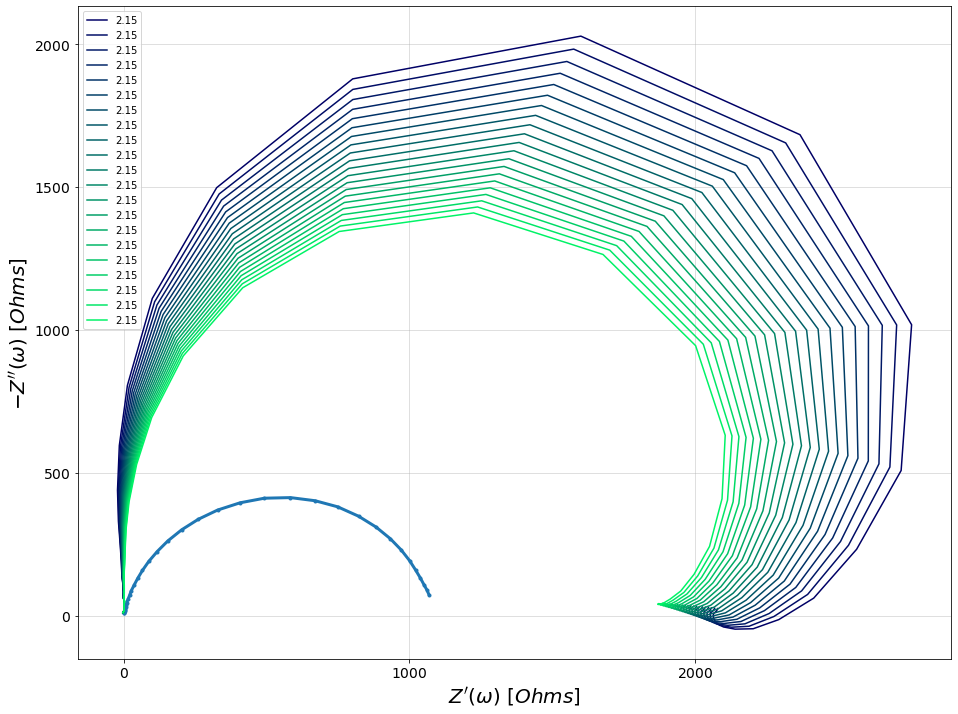

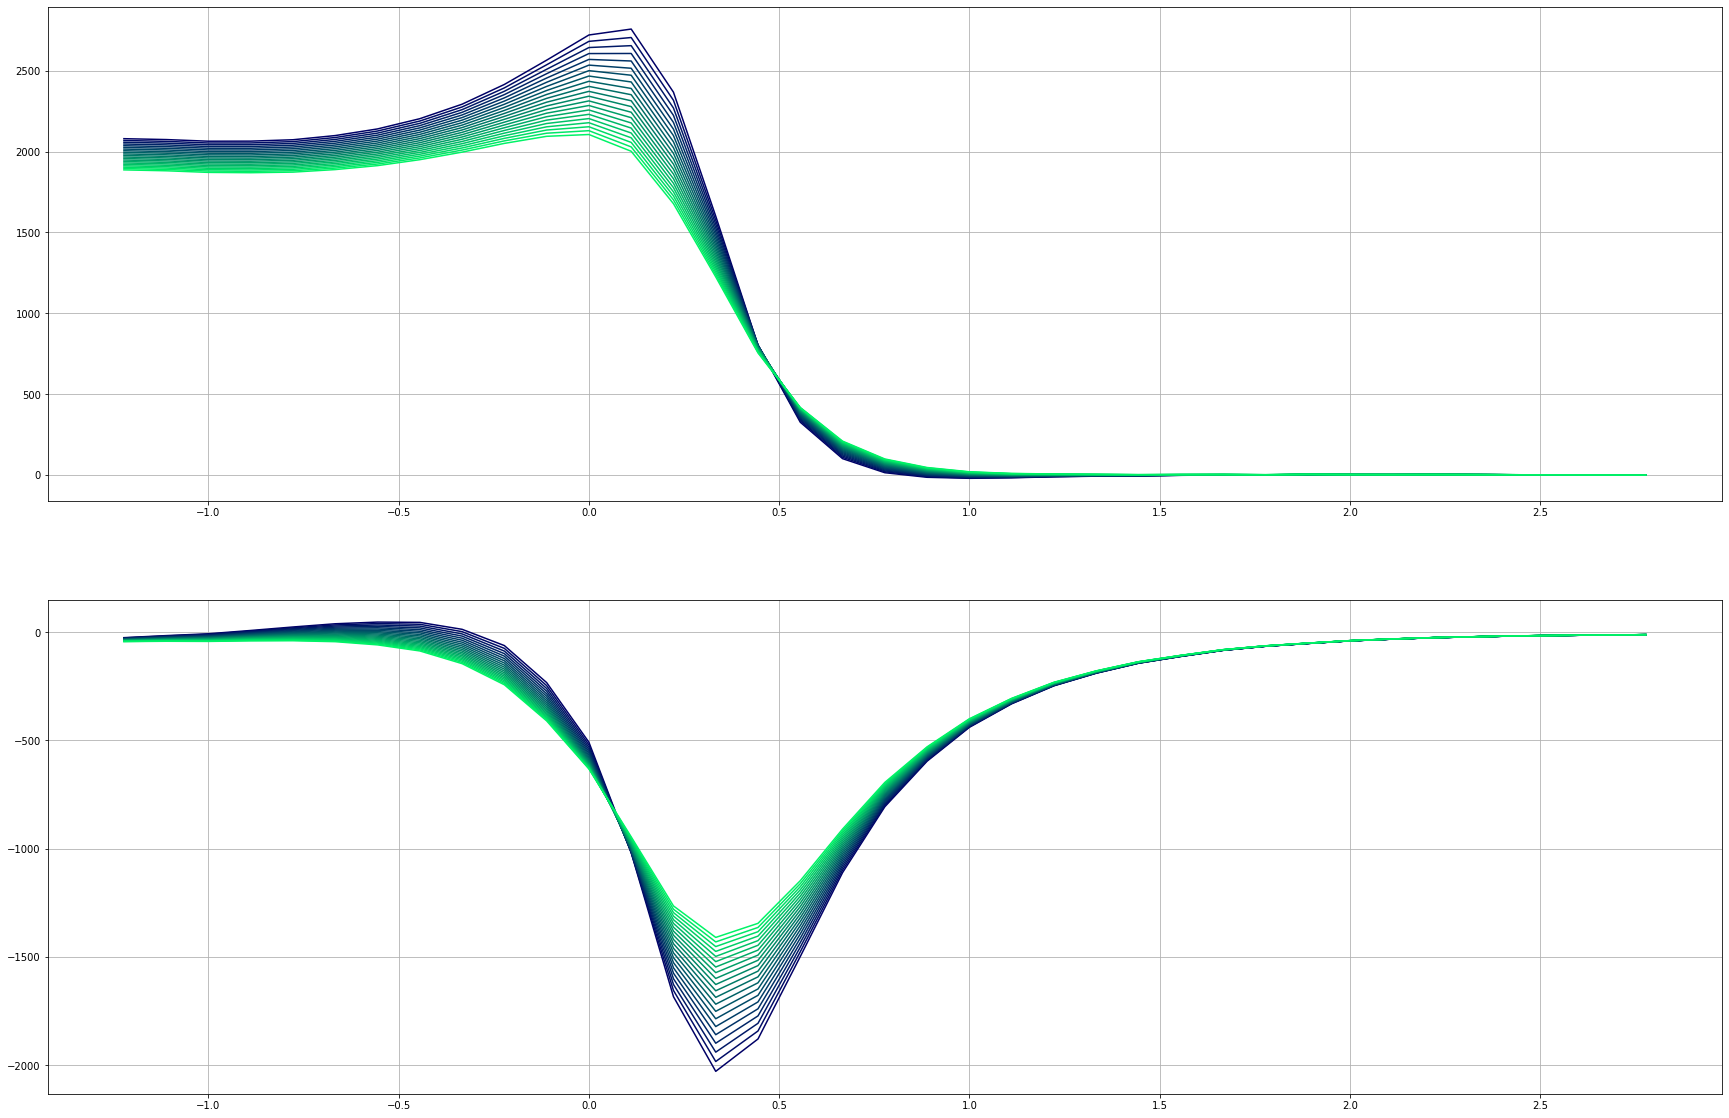

In [171]:
sub_Zg_parallel(f_adj, Z_adj, .7, [3.35, 3.4], num=21)

In [100]:
tg = .91

Zgs = []
Ygs = []

Rgs = np.logspace(2.5, 2.7, num=21)

for Rg in Rgs:
# Zgs.append(G([80, tg], f_adj))
    Zg = G([Rg, tg], f_adj)
    Zgs.append(Zg)
    Ygs.append(1/Zg)
    
Zgs = np.array(Zgs)
Ygs = np.array(Ygs)

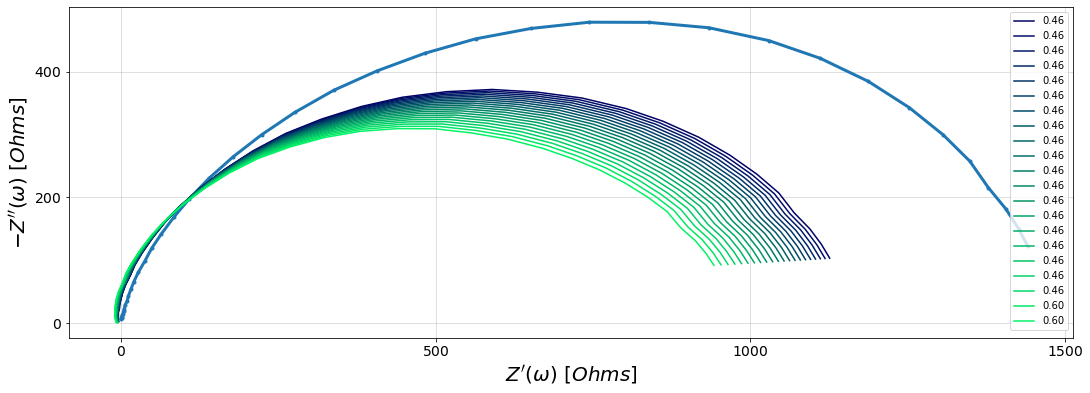

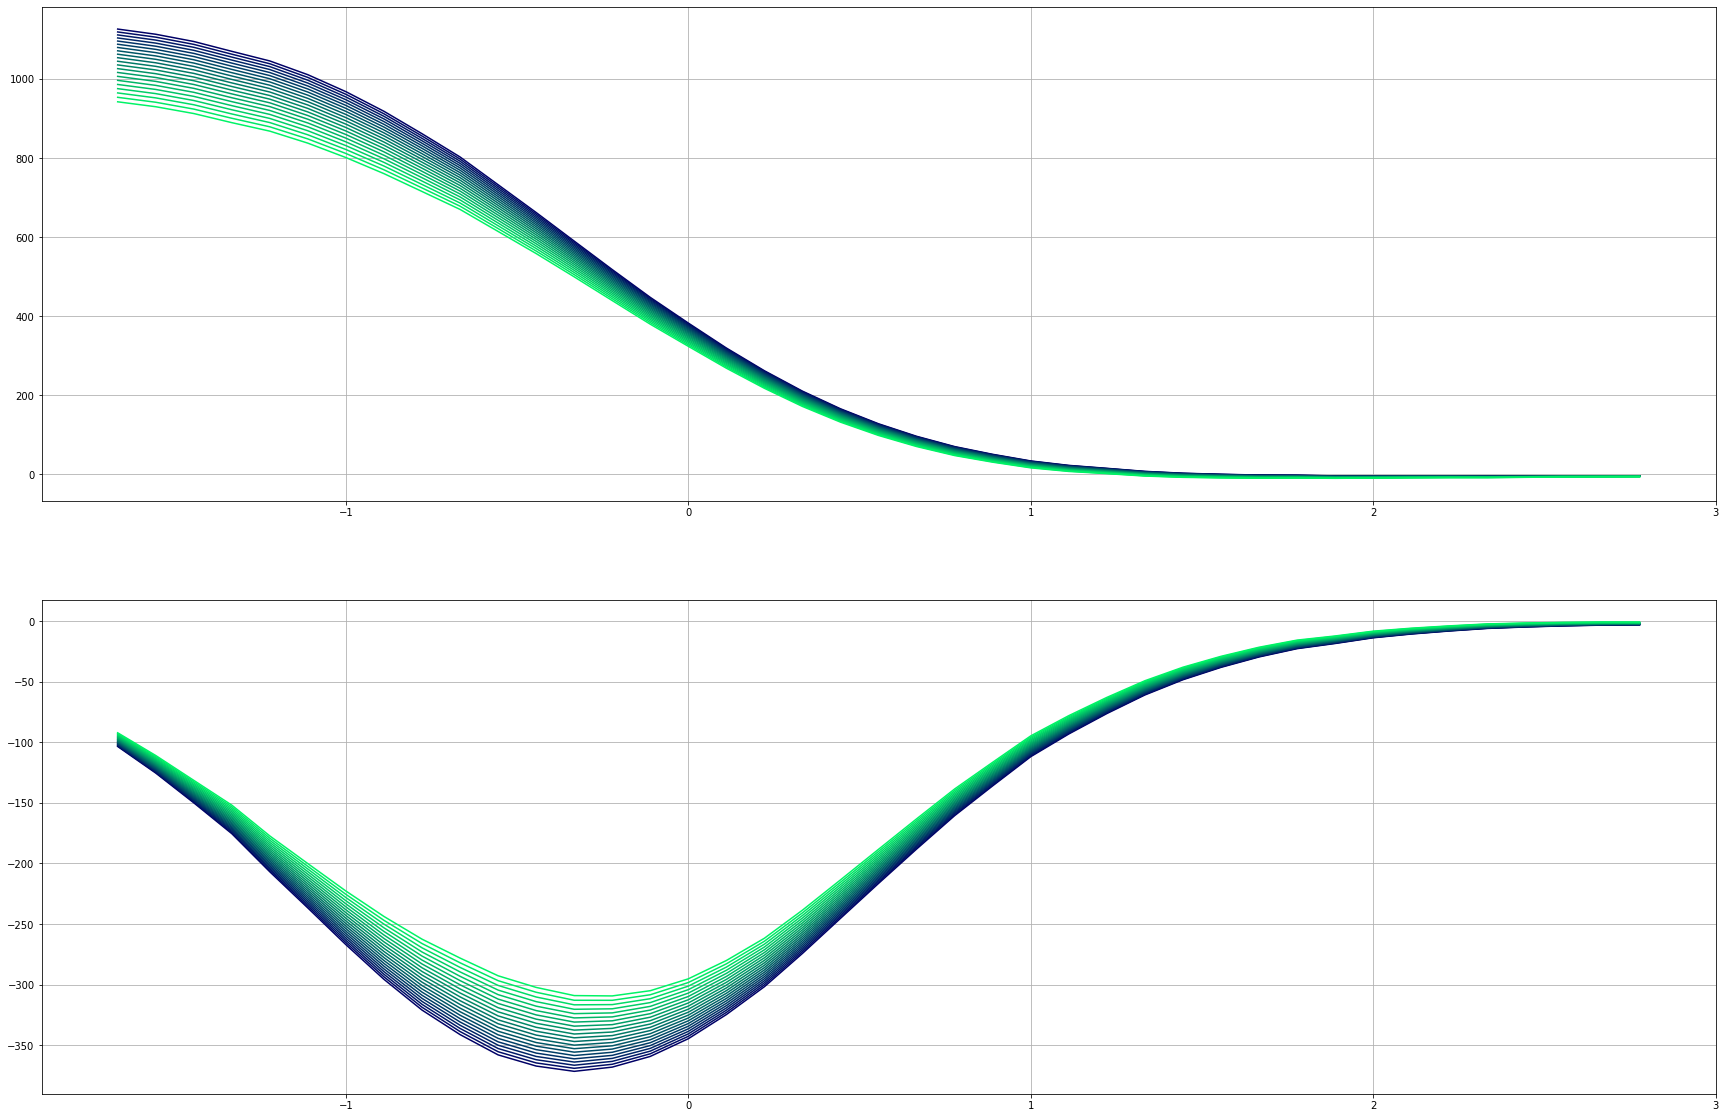

In [101]:
fig, ax = plt.subplots(figsize=(18,12))
fig2, (ax1, ax2) = plt.subplots(nrows=2, figsize=(30,20))
plot_nyquist(ax, f_adj, Z_adj)


for i, Zg in enumerate(Zgs):
    f_p = f_adj[np.argmin(np.imag(Z_adj-Zg))]
    ax.plot(Z_adj.real-Zg.real, -(Z_adj.imag - Zg.imag), label='%.2f' % f_p, c=(0, i/len(Ygs),.4))
    ax1.plot(np.log10(f_adj), Z_adj.real-Zg.real, label='%.2f' % Rgs[i], c=(0, i/len(Ygs),.4))
    ax2.plot(np.log10(f_adj), (Z_adj.imag - Zg.imag), label='%.2f' % Rgs[i], c=(0, i/len(Ygs),.4))
    
# ax.set_xlim(-80, 300)
# ax.set_ylim(-80, 300)
ax1.grid(True)
ax2.grid(True)
ax.legend()
plt.show()

In [144]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*10%*.par')
all_files.sort()

f_name=all_files[-1]
print(f_name)
f0, Z0 = preprocessing.readVersaStudio(f_name)

freqs, Z1 = preprocessing.ignoreBelowX(f0, Z0)

Z = Z1 - Z1.real[0]

C:\Users\shadd\OneDrive\Documents\Python\EIS
C:\Users\shadd\OneDrive\Documents\Python\EIS\Data\LSC_DPB1_FRXAS_700C_100%_EIS_OCV_before2.par


C:\Users\shadd\OneDrive\Documents\Python\EIS


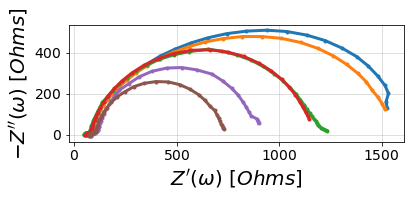

In [172]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*.par')
all_files.sort()

fig, ax = plt.subplots()

for file in all_files:
    f, Z = preprocessing.readVersaStudio(file)
    plot_nyquist(ax, f, Z)

    
# ax.set_xlim(40,150)
# ax.set_ylim(0,100)
plt.show()

In [173]:
all_files

['C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_10%_EIS_OCV_after.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_10%_EIS_OCV_afterFRXAS.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_100%_EIS_OCV_after.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_100%_EIS_OCV_before2.par']

In [143]:
from impedance.validation import linKK

In [ ]:
linKK()